## Pytorch
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [52]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


### Visualize the dataset

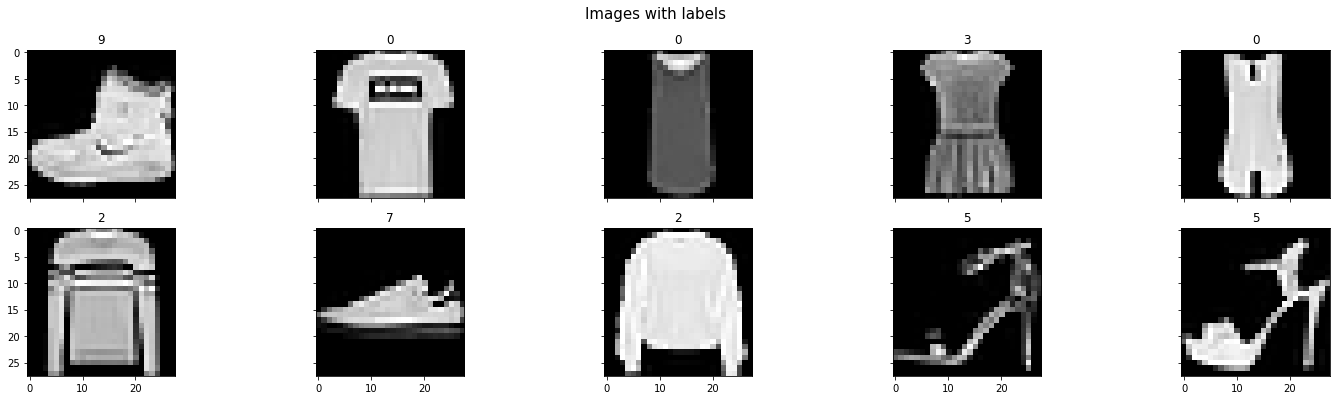

In [32]:
dataiter = iter(train_dataloader)

images, labels = dataiter.next()
images,labels = np.array(images), np.array(labels)

nrow, ncol = 2,5
f,ax=plt.subplots(nrow,ncol,figsize=(ncol*5,nrow*3),sharex=True,sharey=True); ax=ax.flatten();

for i in range(nrow*ncol):
    ax[i].imshow(images[i,0],cmap='gray');
    ax[i].set_title(labels[i]);
    
plt.suptitle('Images with labels',fontsize=15); plt.show();

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten()
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [45]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset); correct = 0;
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss.item(), correct/size

In [46]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    
    return test_loss, correct
    

In [ ]:
epochs = 2000
train_loss, train_acc, test_loss, test_acc = [np.zeros(shape=(epochs,)) for _ in range(4)]
for t in tqdm(range(epochs)):
    train_loss[t], train_acc[t]=train(train_dataloader, model, loss_fn, optimizer)
    test_loss[t], test_acc[t]=test(test_dataloader, model, loss_fn)

f,ax=plt.subplots(1,2,figsize=(15,5),sharex=True);
ax[0].plot(train_loss,'o-',label='Train loss'); ax[0].plot(test_loss,'*-',label='Test loss');
ax[0].legend(frameon=False); sns.despine(offset=10); ax[0].set_xlabel('Epoch'); 
ax[0].set_ylabel('Cross-entropy loss')

ax[1].plot(train_acc,'o-',label='Train acc'); ax[1].plot(test_acc,'*-',label='Test acc');
ax[1].legend(frameon=False); sns.despine(offset=10); ax[1].set_xlabel('Epoch'); 
ax[1].set_ylabel('Accuracy')


plt.show();

 62%|██████▏   | 1231/2000 [4:42:32<2:07:11,  9.92s/it]   